# Connect4 Reinforcement Learning by DQN

In [1]:
import numpy as np
import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from random import random, randint, sample
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os
import time
import tkinter as tk
import torch
import math

In [2]:
#initialize for random seeds/states
seeds=[12345,42,42,42]
def randomize(seed_rng=seeds[0], seed_np=seeds[1], seed_torch=seeds[2], seed_tf=seeds[3]):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    rng = np.random.default_rng(seed_rng)
    np.random.seed(seed_np)
    torch.manual_seed(seed_torch)
    tf.random.set_seed(seed_tf)

randomize()

In [3]:
class paper_game(ABC):
    def __init__(self, start_state):
        self.state=start_state
    
    @abstractmethod
    def transition(state, action, player):
        #return next state
        pass

## 1. Connect4 basic functionality

In [4]:
class connect4(paper_game):
    #state: 6x7 array to represent board config, with 1 representing self-checker, -1 representing opponent-checker, 0 representing empty
    def __init__(self, start_state=np.zeros((6,7), dtype=np.int8), Q_network=None):
        self.state = start_state
        self.turn_count = 0
        self.Q = Q_network
        #self.Q = np.zeros((19683, 9)) - need to change to Q-network somewhere
        
    def transition(self, state, action, player):
        #action: a list/tuple of row and column index to indicate which cell is chosen
        #player: 1 or -1, with 1 being self-checker, -1 being opponent-checker
        #applicable to both tic_tac_toe and Connect-4
        #return next state
        new_state = copy.deepcopy(state)
        new_state[action[0]][action[1]] = player
        return new_state      

    def win_status(self, s, action, player):  
        #note: unlike tic-tac-toe, action is needed for input, to save computation
        #suppose state before action is not winning, so only check lines connected with action
        #s: state before action
        #action: list/tuple/array, unpackable to row and column index to indicate which cell is chosen
        #player: 1 or -1, the player taking the action
        #----return----- 
        #win: whether player wins or not with the action
        #lose means "if" it is opposite player's turn instead, hypothetical only
        w = 3 * player  # use 3 instead of 4 because the action is not yet put into board
        r, c = action
        f = np.fliplr(s) #flip for finding diagonal in opposite direction, i.e. upwards
        c_f = 6 - c      #for use in flipped states
        lines = [s[r:r+4, c].sum()] # vertical line
        for i in range(4):
            lines.append(s[r,  c-i:c+4-i].sum()) #horizontal line
            lines.append(s[r-i:r+4-i, c-i:c+4-i].diagonal().sum()) #diagonal line
            lines.append(f[r-i:r+4-i, c_f-i:c_f+4-i].diagonal().sum()) #diagonal line in opposite direction
        win = w in lines
        lose = -w in lines
        return win, lose   #lose is only hypothetical check here
    
    def action_list(self, state):
        #return array of shape (n, 2), where n is no of possible actions, each represented by row and column
        row_list = 5 - np.sum(abs(state), axis=0)
        col_list = np.where(row_list >= 0)
        act_list = np.dstack((row_list[col_list], col_list))[0]   #use [0] instead of squeeze which causes unexpected shape when only one action is legal
        return act_list    #note: unlike tic-tac-toe, act_list[0] is the first action instead of row indices
    
    def random_move(self, state, act_list=None): #unlike tic-tac-toe, it allows input of short-listed actions
        #return action in array of shape (2,)
        if act_list is None:
            act_list = self.action_list(state)
        i = np.random.randint(len(act_list))
        action = act_list[i]
        return action

    def basic_check(self, state, player=1, act_list=None):       
        #exploit immediate win / then avoid immediate win by opponent; otherwise return empty move
        #act_list: allows input of short-listed actions of player to save computation
        #--------return--------
        #action: action that can win, or if not available then return action that blocks opponent's win
        #win_count: dictionary, no. of ways to win immediately by each player
        #safe_list: actions that opponent cannot win immediately "above", not consider win move or other moves that lose
        #note: safe_list is list of array while act_list is array of array in action_list function
        if act_list is None:
            act_list = self.action_list(state)
        action = []
        block = []
        safe_list = []
        win_count = {1: 0, -1: 0,}
        for a in act_list:
            win, op_win = self.win_status(state, a, player)
            if win:
                action = a
                win_count[player] += 1
            if op_win:
                block = a
                win_count[-player] += 1   #neagtive player means opposite player
            #check if there is trap i.e. whether opponent can win on the same column immediately above the move
            if a[0] == 0: 
                safe_list.append(a)  #highest row has no danger above it
            else:
                s = self.transition(state, a, player=player)
                #simulate opponent move immediately above, along same column
                op_win, _ = self.win_status(s, [a[0]-1, a[1]], -player)  #note: opposite player, so win becomes op_win
                if not op_win:
                    safe_list.append(a)
    
        if len(action)==0:  #if action is still empty
            action = block
        return action, win_count, safe_list  #safe list does not consider win move or block move; it is a list of array, not array of array
    
    def basic_move(self, state, player=1):
        #exploit immediate win and then avoid immediate win by opponent; otherwise random
        #return action
        action, win_count, act_list = self.basic_check(state, player=player)
        if len(action)==0:  
            if len(act_list)==0:  #short list from basic check can be empty if no safe space
                act_list = self.action_list(state)
            action = self.random_move(state, act_list)
        return action
    
    def medium_move(self, state, player=1):
        #exploit immediate win and immeidate checkmate and avoid such by opponent; otherwise random
        #return action
        action, win_count, act_list = self.basic_check(state, player=player)
        if len(action)==0:  
            if len(act_list)==0:  #short list from basic check can be empty if no safe space
                act_list = self.action_list(state)
            else:
                safe_idx = []
                for idx, a in enumerate(act_list): #note: this act_list is safe list from basic_check
                    safe_idx.append(idx)
                    s1 = self.transition(state, a, player=player)
                    op_action, win_c1, op_safe_list = self.basic_check(s1, player=-player)
                    if win_c1[player] > 1 or op_safe_list==[] or (win_c1[player]==1 and (op_action[1:2] not in np.array(op_safe_list)[:,1]) ):  #i.e. checkmate
                        action = a
                        break
                        
                    else:
                        for op_act in op_safe_list:
                            s2 = self.transition(state, op_act, player=-player)
                            a2, win_c2, safe_list2 = self.basic_check(s2, player=player)
                            if win_c2[player]==0:
                                if  win_c2[-player]>1 or safe_list2==[] or (win_c2[-player]==1 and (a2[1:2] not in np.array(safe_list2)[:,1]))  :  #i.e. being checkmated
                                    safe_idx.pop()
                                    break
                if safe_idx != []:
                    act_list = np.array(act_list)
                    act_list = act_list[safe_idx]
        if len(action)==0:
            action = self.random_move(state, act_list)
        return action
  
    def display_board(self, state):
        print('-------------------')
        print(state)
        print('-------------------')
        print(np.array([[0,1,2,3,4,5,6]]))
            
    def display_colour(self, state):
        fig, ax = plt.subplots()
        im = ax.imshow(state)
        ax.set_xticks(np.arange(7))
        ax.set_yticks(np.arange(6))
        ax.set_xticklabels(np.arange(7))
        ax.set_yticklabels(np.arange(6))
        for i in range(6):
            for j in range(7):
                text = ax.text(j, i, state[i, j], ha="center", va="center", color="g")
        ax.set_title("1: computer; -1: you")
        fig.tight_layout()
        plt.show()
    
    def play_game(self, starter = 1, policy_function=None):
        state = np.zeros((6,7), dtype=np.int8)
        player = starter
        endgame = False
        t = 0
        if policy_function is None:
            policy_function = self.medium_move 
        player_dict = {1: "computer", -1: "you",}
        #self.display_colour(state)
        while not endgame:
            if player == -1:
                valid = False
                while not valid:
                    j = int(input('enter column: (0-6)\n')) 
                    valid = j in self.action_list(state)[:,1]          #data validation on column input
                    if not valid:
                        print('Invalid column input!')
                        if j in [0,1,2,3,4,5,6]:
                            print('The column is full!')
                i = (5 - np.sum(abs(state),axis=0))[j]
            else:
                i, j = policy_function(state)
            player_win, _ = self.win_status(state, [i,j], player)
            state[i,j] = player
            self.display_colour(state)  
            if player_win:
                print('The winner is '+player_dict[player])
            player *= -1
            t += 1
            endgame = player_win or t==42
        if not player_win:
            print('This is a draw.')


    def greedy_policy(self, state, network):
        with torch.no_grad():
            network.eval()
            q = np.array(network(convert_state(state))).squeeze()
            network.train()
        act_col_list = self.action_list(state)[:,1]
        legal_move_q = np.array(q[act_col_list])
        j = act_col_list[np.argmax(legal_move_q)]
        i = (5 - np.sum(abs(state), axis=0))[j]
        action =[i, j]
        return action
    
    def step(self,action,network):
        #action: one of column numbers 0-6
        #network: Q network
        #return-----------
        #state: new state, numpy format
        #reward: 0, 100 or -100
        #endgame: boolean, end game or not
        #in this function, the agent will play one step according to the game's state.
        #Also, the rewards of each action would be saved in the replay memory.
        reward = 0   
        endgame = False
        
        j = action
        i = 5 - np.sum(abs(self.state[:,j]))
        win = self.win_status(self.state,[i,j], 1)[0]
        self.state[i,j] = 1
        self.turn_count += 1

        if win:  
            reward = 100
            endgame = True
        else:
            if self.turn_count == 42:
                endgame = True
            else:
                i,j = self.greedy_policy(-self.state, network)    #negative state for opponent
                opponent_win = self.win_status(self.state, [i,j], -1)[0]  #-1 to indicate opponent
                self.state[i,j] = -1
                self.turn_count += 1
                if opponent_win:    
                    reward = -100
                    endgame = True
                if self.turn_count == 42:
                    endgame = True
        
        return_state = copy.deepcopy(self.state)

        return return_state, reward, endgame

    def win_p100(self,network, difficulty=0): 
        #the agent would play 100 games with the random or medium moves
        #and the result is the number of games that agent has won
        self.Q = network
        choices = [-1,1]*50
        win_count = 0
        lose_count = 0
        draw_count = 0
        handcraft_agent = [self.random_move, self.basic_move, self.medium_move]
        opponent_policy = handcraft_agent[difficulty]
        for i in range(100):
            state = np.zeros((6,7), dtype=np.int8)
            current_turn = choices[-1]
            endgame = False
            t = 0
            while not endgame:
                if current_turn == 1:
                    i,j = self.greedy_policy(state, network)
                else:
                    i,j = opponent_policy(-state)        #negative state for opponent
                    # i,j = self.medium_move(state,-1)      
                t += 1

                if self.win_status(state,[i,j] ,1)[0]:
                    win_count += 1
                    endgame = True
                elif self.win_status(state, [i,j], -1)[0]:
                    lose_count += 1
                    endgame = True
                elif t == 42:
                    draw_count += 1
                    endgame = True
                    
                state[i,j] = current_turn
                current_turn *= -1
            choices = choices[:-1]
        return win_count, lose_count, draw_count


    def play_DQN(self, network, starter = 1,):
        #playing against the agent which decides each move based on a Q network
        self.Q = network
        state = np.zeros((6,7), dtype=np.int8)
        current_turn = starter
        endgame = False
        t = 0
        player_dict = {1: "computer", -1: "you",}
        while not endgame:
            if current_turn == 1:
                i, j = self.greedy_policy(state, network)
            else:
                j = int(input('enter column: (0-6)\n'))
                i = (5 - np.sum(abs(state),axis=0))[j]           

            if self.win_status(state,[i,j] ,current_turn)[0]:
                print('The winner is '+player_dict[current_turn])
                endgame = True

            # elif self.win_status(state,[i,j] ,current_turn)[1]:
            #     print(f'{current_turn} lose')
            #     endgame = True

            elif t == 42:
                endgame = True
                print('draw')
                
            state[i,j] = current_turn  
            current_turn *= -1
            t += 1
            self.display_colour(state)

    def reset(self):
        #reset the games state to the initial values
        self.state = np.zeros((6,7), dtype=np.int8)
        self.turn_count = 0
        return self.state
        # self.display_colour(self.state)

### Let's play Connect4 with hand-crafted agent first

In [5]:
playHandcraft = False
if playHandcraft:
    test1 = connect4()
    test1.play_game()

In [6]:
if playHandcraft:
    test2 = connect4()
    test2.play_game(starter=-1)

## 2. Memory and state conversion

In [7]:
#each memory of the game consists of the current state, the action of the agent, 
#the next state after the action, and the reward of that action.

from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_state(state):
    #converting each state to a flatten tensor
    #state = state.flatten()   #flatten inside NN instead if needed
    state_tensor = torch.tensor(state, device=device).unsqueeze(0)
    return state_tensor
    
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.counter = 0
        self.total = 0

    def push(self, state, action, next_state, reward):
        #saving memory
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        state_tensor = convert_state(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = convert_state(next_state)
            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)
        reward = torch.tensor([reward], device=device).unsqueeze(0)/100. # reward scaling
        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, prioritized=False, alpha=0.5, beta=0):
        if prioritized:
            rewards = torch.tensor([self.memory[i].reward for i in range(len(self.memory))])
            priority = torch.abs(rewards/100) + 0.01
            pp = torch.pow(priority, alpha)
            prob = pp/torch.sum(pp)
            N = len(self.memory)
            weight = torch.pow((N*prob),-beta)
            prob_w = np.asarray(torch.mul(prob, weight)).astype('float64')
            p = prob_w/np.sum(prob_w)
            rnd_indices = np.random.choice(N, batch_size, p=p)
            sample=[self.memory[i] for i in rnd_indices]
        else:
            sample = sample(self.memory, batch_size)
        return sample

    def __len__(self):
        return len(self.memory)

## 3. Approximate Q-matrix by neural network

In [8]:
#Q networks of the game, there are several networks in this part, but the first one is currently working

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.bn1 = nn.BatchNorm1d(size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.bn2 = nn.BatchNorm1d(size_hidden)
        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.bn3 = nn.BatchNorm1d(size_hidden)
        self.fc4 = nn.Linear(size_hidden, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        h1 = F.relu(self.bn1(self.fc1(x.float())))
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h3 = F.relu(self.bn3(self.fc3(h2)))
        output = self.fc4(h3.view(h3.size(0), -1))
        return output

class DQN_CNN(nn.Module):
    def __init__(self, k=128, n=256, p=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 4, padding='same') #2D convolution layer, k channels - kernels of 3x3, 
        self.conv2 = nn.Conv2d(k, 4*k, 4, padding='same') ##2D convolution layer, 4k channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, 7)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
OBS_SIZE = 42    #size of the state
HIDDEN_SIZE = 128    #hidden nodes of the network
ACTION_SIZE = 7     #number of actiones and nodes in the last layer

# Q_network = NewDQN(OBS_SIZE, ACTION_SIZE).to(device)
# Q_target = NewDQN(OBS_SIZE, ACTION_SIZE).to(device)
# Q_target.load_state_dict(Q_network.state_dict())
# Q_target.eval()

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

# Q_network = DQN_CNN().to(device)
# Q_target = DQN_CNN().to(device)
# Q_target.load_state_dict(Q_network.state_dict())
# Q_target.eval()

#updating Q_target network after a certain epoch
TARGET_UPDATE = 20

optimizer = optim.SGD(Q_network.parameters(), lr=0.01)
memory = ReplayMemory(40000)    #capacity of the memory

## 4. Epsilon-Greedy Policy

In [10]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon, Q_network=Q_network):
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
        self.Q_network = Q_network
                
    def __call__(self, state):
        is_greedy = random() > self.epsilon
        if is_greedy :        # we select greedy action
            with torch.no_grad():
                self.Q_network.eval()
                q = np.array(self.Q_network(convert_state(state))).squeeze()
                self.Q_network.train()
            row_list = 5 - np.sum(abs(state.detach().cpu().numpy().squeeze()), axis=0)
            act_col_list = np.where(row_list >= 0)[0]
            legal_move_q = np.array(q[act_col_list])
            index_action = act_col_list[np.argmax(legal_move_q)]
        else:
            index_action = randint(0,6)     # we sample a random action
        return index_action
                
    def update_epsilon(self):
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start

#creating the policy, with specific factors        
policy = E_Greedy_Policy(0.99, decay=0.999999, min_epsilon=0.05, Q_network=Q_network)

## 5. One step of Optimization

In [11]:
BATCH_SIZE = 32
GAMMA = 0.99
config = {'double':False, 'n-step':1, 'prioritized':False, 'alpha':0.5, 'beta':0.1}  #set vanilla DQN as default


def optimize_model(config=config, GAMMA=GAMMA, BATCH_SIZE=BATCH_SIZE, Q_network=Q_network, Q_target=Q_target, memory=memory):
    transitions = memory.sample(BATCH_SIZE, prioritized=config['prioritized'], alpha=config['alpha'], beta=config['beta'])
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    #if len(batch.next_state)==0:
        #print('empty batch.next_state')
    #if batch.next_state == [None]*BATCH_SIZE:
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    # print(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)
    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()

    return loss

## 6. Training by Self-play

In [12]:
num_episodes = 20000
config={'double':False, 'n-step':1, 'prioritized':True, 'alpha':0.5, 'beta':0.1}

def self_start(i_episode):
    i_episode = 0
    game = connect4()
    game.reset()
    done = False
    total_reward = 0
    if i_episode % 2 == 0:
        j = np.random.choice(7, 1, p=[0.05, 0.1, 0.15, 0.4, 0.15, 0.1, 0.05])[0]
        game.state[5, j] = -1
        game.turn_count += 1
    state=game.state
    return game, total_reward, done, state

def step_memory(game, total_reward, memory, policy=policy, Q_target=Q_target):
    # Get action and act in the world
    state=game.state
    state_tensor = convert_state(state)
    action = policy(state_tensor)
    next_state, reward, done = game.step(action, Q_target)
    total_reward += float(reward)
    # Observe new state
    if done:
        next_state = game.reset()
        #next_state = None
    # Store the transition in memory
    memory.push(state, action, next_state, float(reward))
    return memory, total_reward, done

def train(num_episodes=num_episodes, policy=policy, config=config, GAMMA=GAMMA, BATCH_SIZE=BATCH_SIZE, Q_network=Q_network, Q_target=Q_target, memory=memory,seeds=seeds):
    start_time=time.time()
    randomize(*seeds)
    policy.reset()
    game = connect4()
    game.reset()
    rewards_history = []
    win_percent = []
    win = [[],[],[]]
    memory_filled = False
    
    # Warmup phase!
    while not memory_filled:
        i_episode=0
        game, total_reward, done, state = self_start(i_episode)
        while not done:
            # Get action and act in the world
            memory, total_reward, done = step_memory(game, total_reward, memory)
            if done:
                i_episode += 1
        memory_filled = memory.capacity == len(memory)
    print('Done with the warmup')
    
    # training phase
    for i_episode in range(num_episodes):
        # New game at every run
        game, total_reward, done, state = self_start(i_episode)
        while not done:
            # Get action and act in the world
            memory, total_reward, done = step_memory(game, total_reward, memory)
            # Perform one step of the optimization
            started_training = True
            l = optimize_model(config=config, GAMMA=GAMMA, BATCH_SIZE=BATCH_SIZE, Q_network=Q_network, Q_target=Q_target, memory=memory)

        policy.update_epsilon()
        rewards_history.append( float(total_reward) )

        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            Q_target.load_state_dict(Q_network.state_dict())
    
        if (i_episode+1) % 2500 == 0:
            game.Q = Q_target
            for i in range(3):
                win[i], _, _ = game.win_p100(Q_target, difficulty=i)
            win_percent.append([*win])       #if append win directly, win repeats every row as it is stored as object
            r = rewards_history[-10:]
            average_reward = sum(r)/len(r)
            print('Training at episode {}:--------------------'.format(i_episode+1))
            print('reward unscaled:',  total_reward, 'eps: ', policy.epsilon, ' loss:', l.detach().cpu())
            print( 'average rewards unscaled in previous 10 games:', average_reward)
            print('300 games greedy evaluation: {} win random, {} win basic, {} win medium'.format(*win))
    win_percent=np.array(win_percent)
    end_time=time.time()
    print('Training ',num_episodes,' episodes done in {:.2f} seconds'.format(end_time-start_time))
    return Q_network, rewards_history, win_percent

In [13]:
Q_network, rewards_history, win_percent = train()

/var/folders/wz/clvs5gsd7jl5jxf044nvdvw00000gn/T/ipykernel_60329/522593627.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, device=device).unsqueeze(0)


Done with the warmup
Training at episode 2500:--------------------
reward unscaled: -100.0 eps:  0.9875280899390025  loss: tensor(0.0473)
average rewards unscaled in previous 10 games: -100.0
300 games greedy evaluation: 79 win random, 64 win basic, 52 win medium
Training at episode 5000:--------------------
reward unscaled: -100.0 eps:  0.9850623519379572  loss: tensor(0.0399)
average rewards unscaled in previous 10 games: -60.0
300 games greedy evaluation: 92 win random, 78 win basic, 75 win medium
Training at episode 7500:--------------------
reward unscaled: -100.0 eps:  0.9826027705859718  loss: tensor(0.0847)
average rewards unscaled in previous 10 games: -80.0
300 games greedy evaluation: 82 win random, 68 win basic, 77 win medium
Training at episode 10000:--------------------
reward unscaled: -100.0 eps:  0.9801493305106447  loss: tensor(0.0437)
average rewards unscaled in previous 10 games: -100.0
300 games greedy evaluation: 72 win random, 62 win basic, 55 win medium
Training

In [14]:
memory.memory.shape

AttributeError: 'list' object has no attribute 'shape'

In [17]:
win_percent

array([[74, 66, 63],
       [74, 66, 63],
       [74, 66, 63],
       [74, 66, 63],
       [74, 66, 63],
       [74, 66, 63],
       [74, 66, 63],
       [74, 66, 63]])

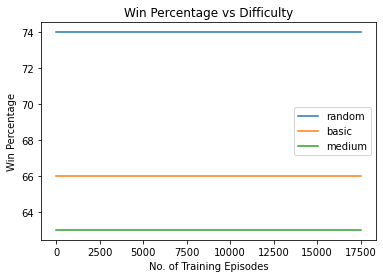

In [16]:
plt.plot([i*2500 for i in range(8)], win_percent[:,0], label='random')
plt.plot([i*2500 for i in range(8)], win_percent[:,1], label='basic')
plt.plot([i*2500 for i in range(8)], win_percent[:,2], label='medium')

plt.xlabel('No. of Training Episodes')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs Difficulty')
plt.legend()
plt.show()

### Let's play Connect4 with DQN agent

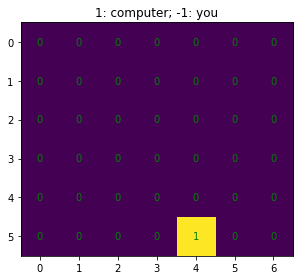

enter column: (0-6)
3


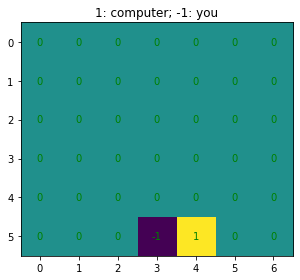

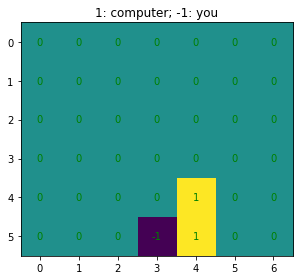

enter column: (0-6)
3


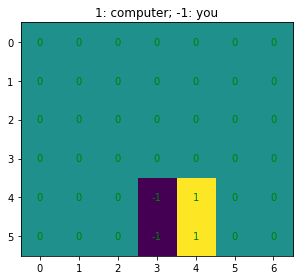

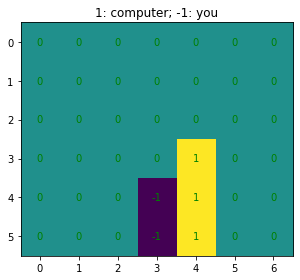

enter column: (0-6)
4


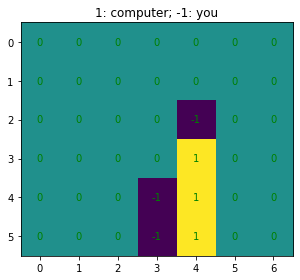

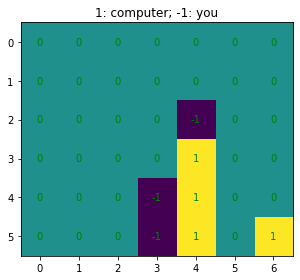

enter column: (0-6)
3


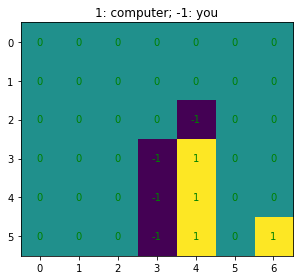

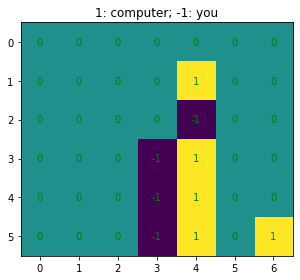

enter column: (0-6)
3
-1 wins


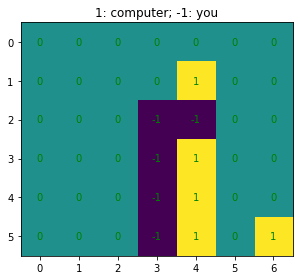

In [18]:
playWithDQN = True
if playWithDQN:
    test_DQN_1 = connect4()
    test_DQN_1.play_DQN(Q_network)

enter column: (0-6)
3


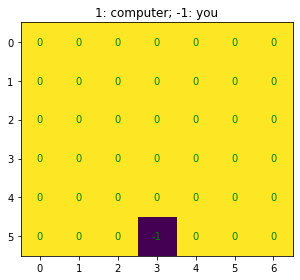

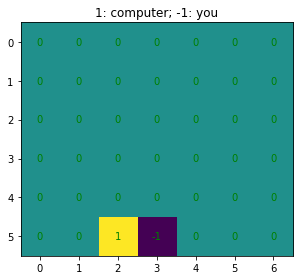

enter column: (0-6)
3


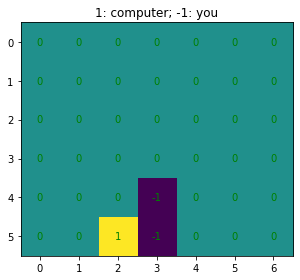

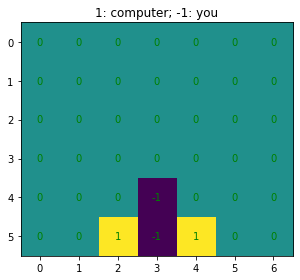

enter column: (0-6)
3


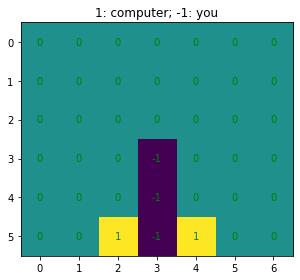

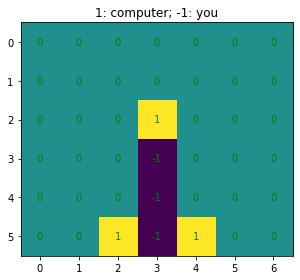

enter column: (0-6)
4


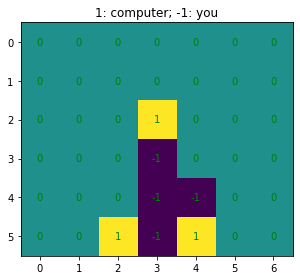

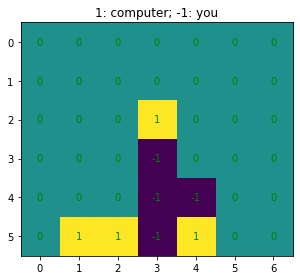

enter column: (0-6)
2


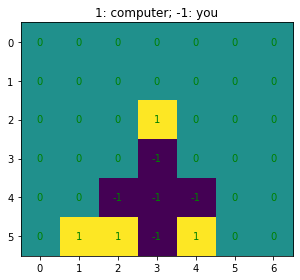

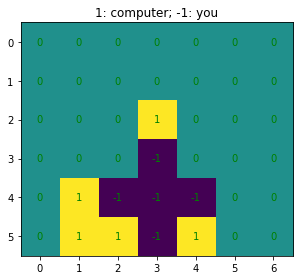

enter column: (0-6)
1


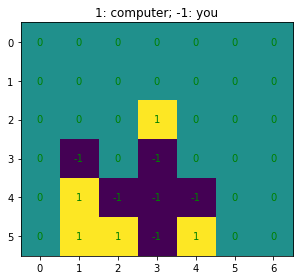

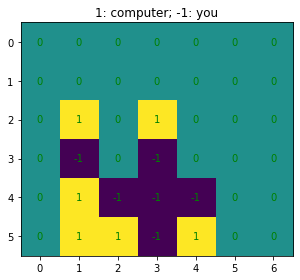

enter column: (0-6)
2


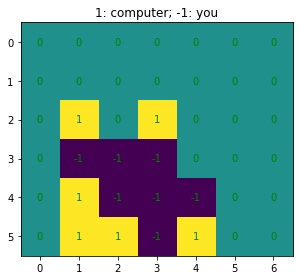

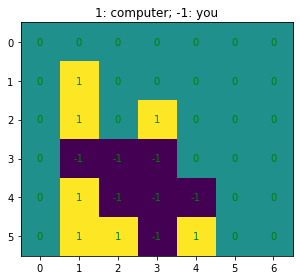

enter column: (0-6)
4
-1 wins


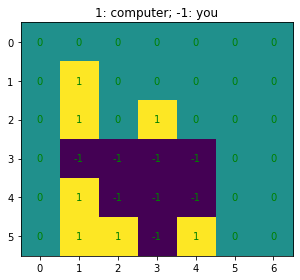

In [19]:
if playWithDQN:
    test_DQN_2 = connect4()
    test_DQN_2.play_DQN(Q_network, starter=-1)

In [ ]:
torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
torch.save(model.state_dict(), PATH)
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()